In [21]:
#Importing the libaries and modules
import os
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Set the data directories for training and testing data
train_dir = './Data/train'
test_dir = './Data/test'

# Set the desired dimensions for the resized images
new_size = (128, 128)

# Load the training data
train_data = []
train_labels = []
label_mapping = {}
label_index = 0
for emotion_dir in os.listdir(train_dir):
    emotion_path = os.path.join(train_dir, emotion_dir)
    for img_path in glob.glob(os.path.join(emotion_path, '*.png')):
        img = Image.open(img_path)

        # Resize the image
        resized_image = img.resize(new_size)

        train_data.append(np.array(resized_image))
        if emotion_dir not in label_mapping:
            label_mapping[emotion_dir] = label_index
            label_index += 1
        train_labels.append(label_mapping[emotion_dir])

# Load the test data
test_data = []
test_labels = []
for emotion_dir in os.listdir(test_dir):
    emotion_path = os.path.join(test_dir, emotion_dir)
    for img_path in glob.glob(os.path.join(emotion_path, '*.png')):
        img = Image.open(img_path)

        # Resize the image
        resized_image = img.resize(new_size)

        test_data.append(np.array(resized_image))
        test_labels.append(label_mapping[emotion_dir])

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Normalize the pixel values to the range (0, 1)
train_data = train_data / 255.0
test_data = test_data / 255.0

In [23]:
# Define the model architecture by using the sequential API
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Convert the labels to one-hot encoded format
from tensorflow.keras.utils import to_categorical

num_classes = 7
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [25]:
# Set up early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Training the model and assigning the history object
history = model.fit(train_data, train_labels, epochs=50, batch_size=64, 
                    validation_data=(test_data, test_labels),
                    callbacks=[early_stopping, lr_reducer])


Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.4231 - loss: 1.2022 - val_accuracy: 0.6646 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.6526 - loss: 0.7946 - val_accuracy: 0.7357 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.7187 - loss: 0.6545 - val_accuracy: 0.7718 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.7789 - loss: 0.5478 - val_accuracy: 0.7835 - val_loss: 0.5248 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8082 - loss: 0.4761 - val_accuracy: 0.8048 - val_loss: 0.5006 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.8359 - loss: 0.4258 - val_accuracy: 0.8032 - val_loss: 0.4842 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.8

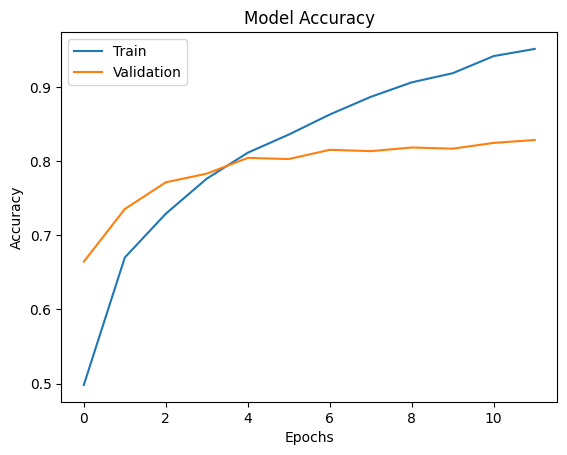

In [26]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

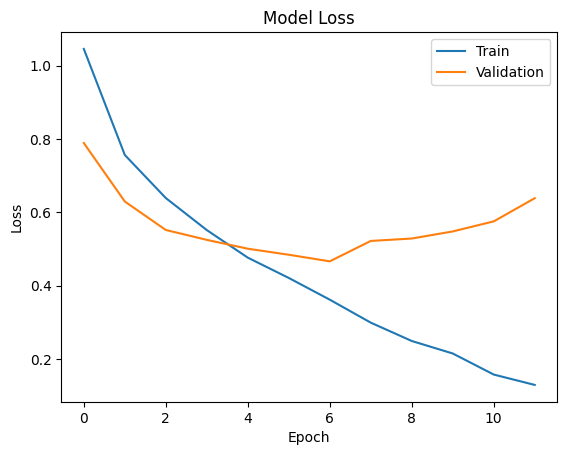

In [27]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [28]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Calculate additional evaluation metrics like precision, recall and F1 score
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
test_labels_classes = np.argmax(test_labels, axis=1)

precision = precision_score(test_labels_classes, y_pred_classes, average='macro')
recall = recall_score(test_labels_classes, y_pred_classes, average='macro')
f1 = f1_score(test_labels_classes, y_pred_classes, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8418 - loss: 0.5524
Test Loss: 0.6383667588233948
Test Accuracy: 0.8289200663566589
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Precision: 0.8314885092124196
Recall: 0.8233474510320061
F1-score: 0.8269714629047726


In [29]:
# Save the trained model
model.save('emotion_detection_model.keras')